## 캐글 경진대회 따라해보기

#### 학습목표
* 데이터 사이언스 관련 최대 커뮤니티인 캐글의 경진대회에 직접 참여해서 문제를 해결해본다.
* 캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해본다.
* 앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출해본다.
* 하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아본다.
* Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올려본다.

#### 준비물

* `xgboost`, `lightgbm`, `missingno`

### baseline 모델

baseline : 문제해결을 시작할 때 쉽게 사용해볼 수 있는 샘플

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍')

얍


In [2]:
train_df_train_path = 'C:/project/aiffel_exp/exp5_kaggle/train.csv'
df_test_df_train_path = 'C:/project/aiffel_exp/exp5_kaggle/test.csv'

print(train_df_train_path)
print(df_test_df_train_path)

C:/project/aiffel_exp/exp5_kaggle/train.csv
C:/project/aiffel_exp/exp5_kaggle/test.csv


### 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [10]:
df_train = pd.read_csv(train_df_train_path)
df_test = pd.read_csv(df_test_df_train_path)
print('train df_train dim : {}'.format(df_train.shape))
print('df_test df_train dim : {}'.format(df_test.shape))

train data dim : (15035, 21)
sub data dim : (6555, 20)


In [11]:
y = df_train['price']
del df_train['price']

print(df_train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [14]:
train_len = len(df_train)
df_train = pd.concat((df_train, df_test), axis=0)

print(len(df_train))

21590


<AxesSubplot:>

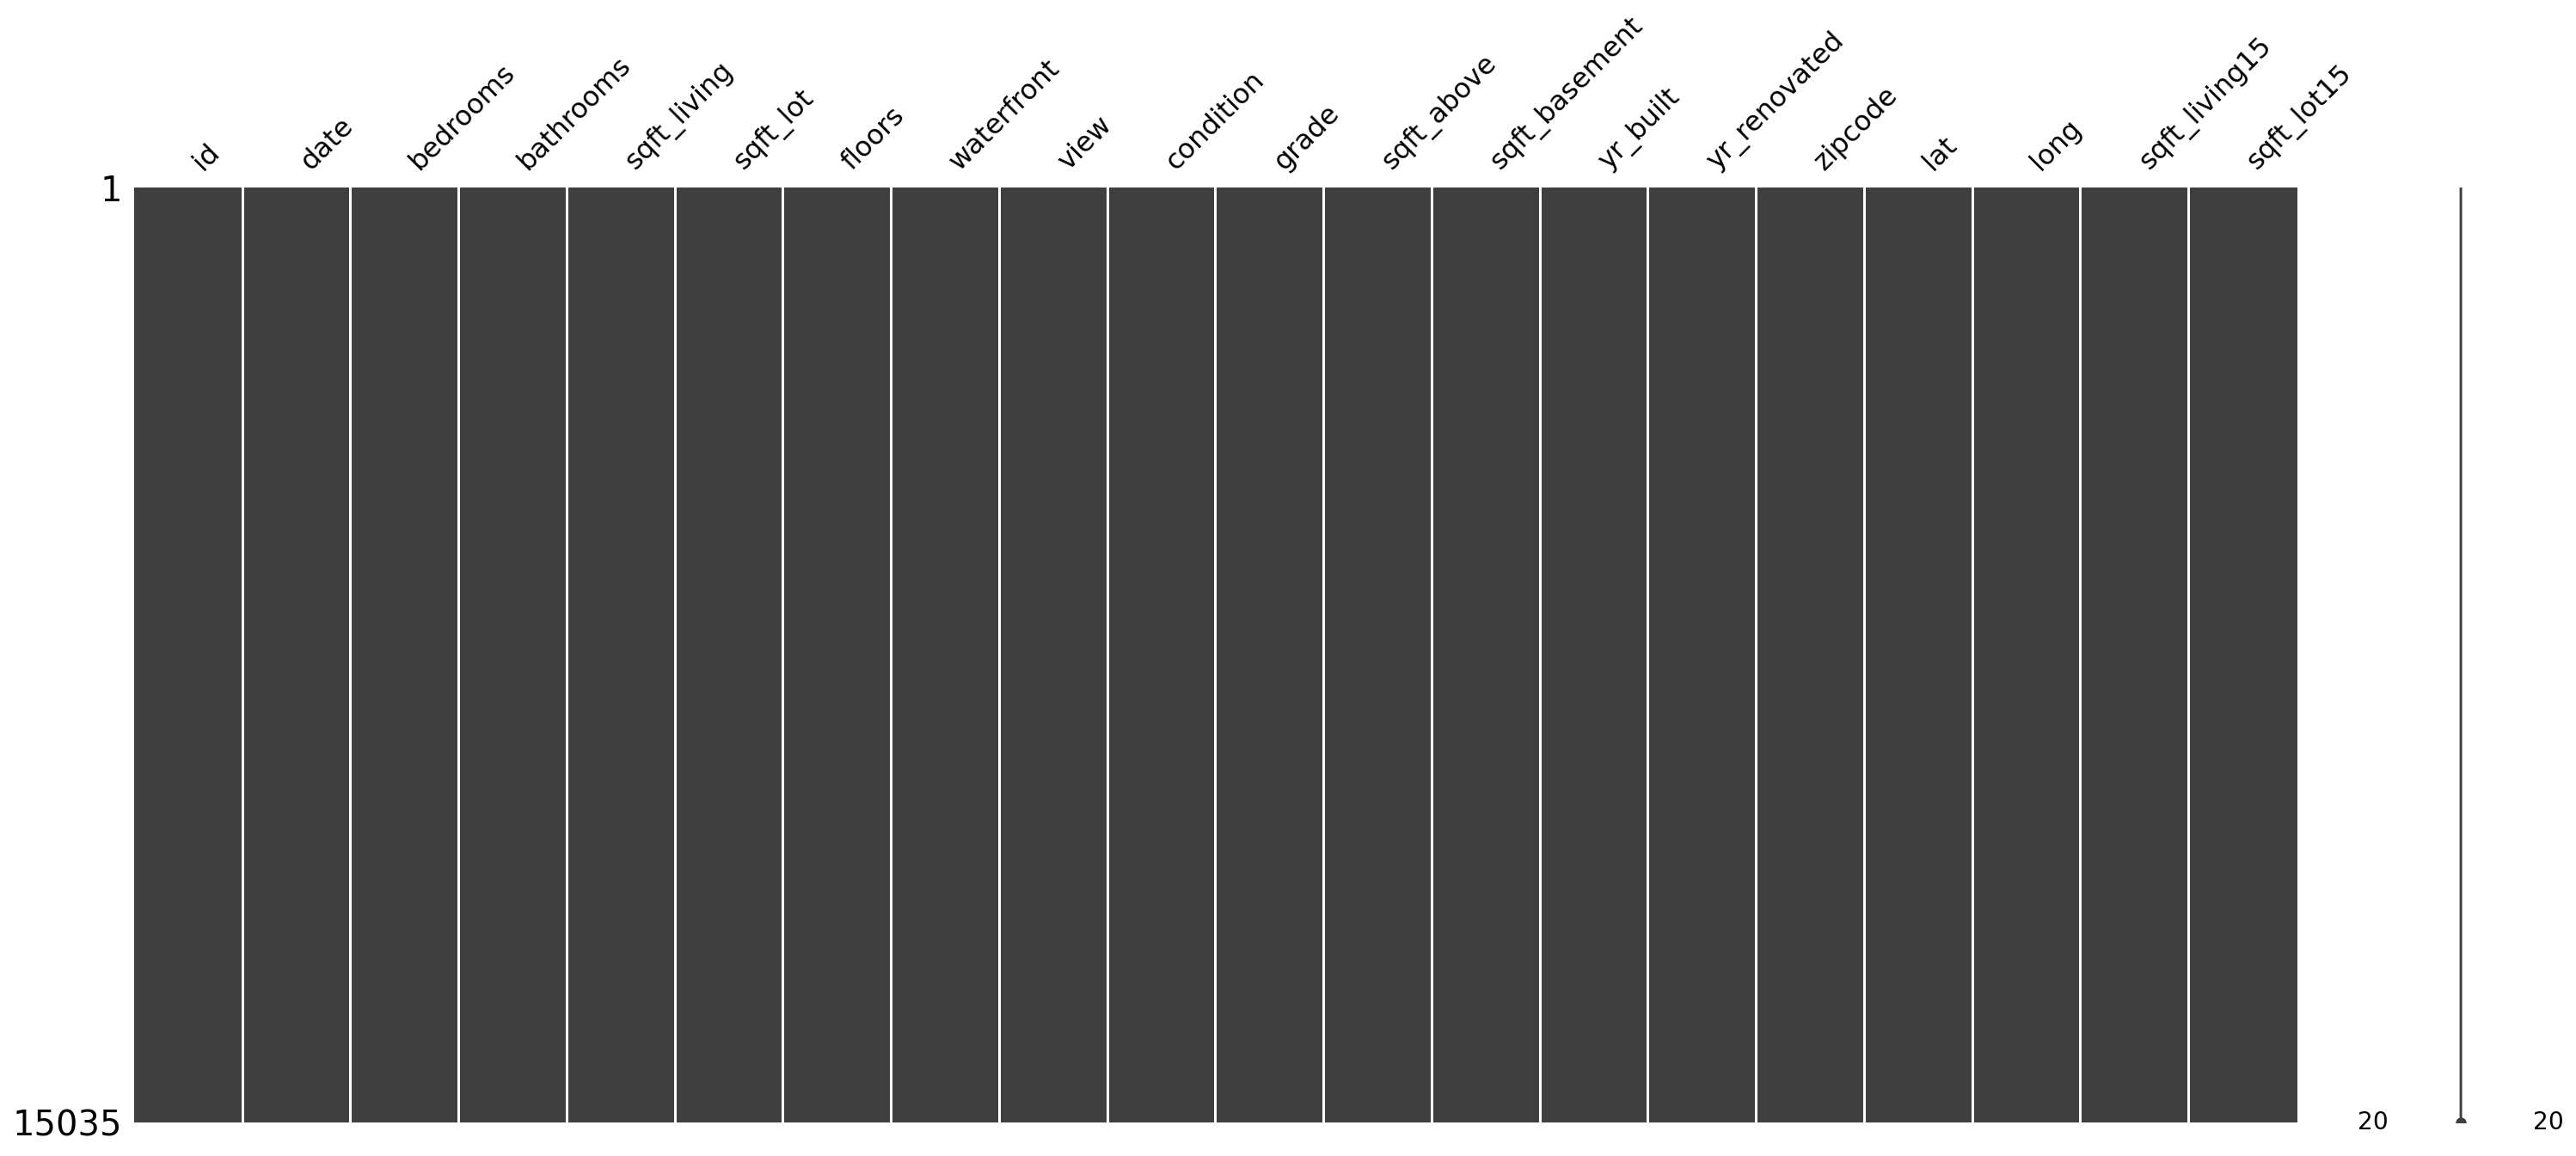

In [13]:
msno.matrix(df_train)

In [15]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(df_train['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6550    False
6551    False
6552    False
6553    False
6554    False
Name: id, Length: 21590, dtype: bool


In [16]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_df_train = df_train.loc[null_check, 'id']
null_df_train.head()

Series([], Name: id, dtype: int64)

In [17]:
# 3. 결측치인 데이터의 개수를 셉니다.
print('{}: {}'.format('id', len(null_df_train.values)))

id: 0


In [18]:
# 한 번에 뿅!
print('{} : {}'.format('id', len(df_train.loc[pd.isnull(df_train['id']), 'id'].values)))

id : 0


In [19]:
for c in df_train.columns:
    print('{} : {}'.format(c, len(df_train.loc[pd.isnull(df_train[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [14]:
df_test_id = df_train['id'][train_len:]
del df_train['id']

print(df_train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [16]:
'str(x[:6]) 으로 처리한 것은 20141013T000000 형식의 데이터를 연/월 데이터만 사용하기 위해 201410까지 자르기 위한 것'
df_train['date'] = df_train['date'].apply(lambda x : str(x[:6])) 

df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 각 변수들의 분포 확인
전체 데이터들의 분포를 확인합니다.
특히 너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로 다듬는 작업을 합니다.

아래 시각화 코드를 통해 id 컬럼을 제외한 19개 컬럼에 대해 한 번에 모든 그래프를 그려줍니다.
10행 2열의 df_testplot에 그래프를 그리기 위해 2중 for문을 사용하고 있군요.

그래프의 종류는 sns.kdeplot을 사용합니다.
kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수입니다.

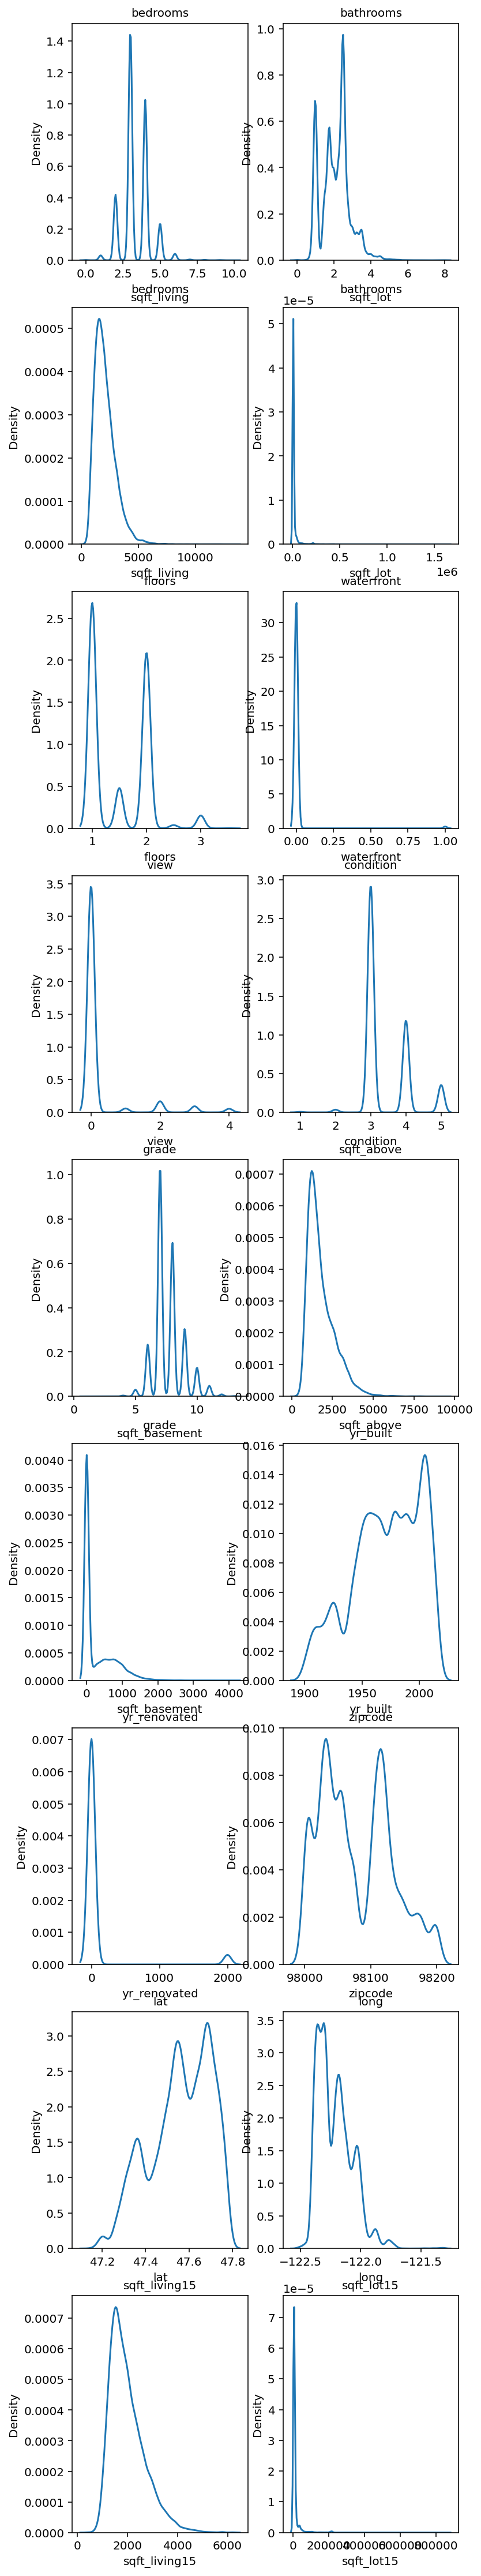

In [22]:
fig, ax = plt.df_testplots(9, 2, figsize=(6, 40))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = df_train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(df_train=df_train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=10)
        count += 1
        if count == 19 :
            break

그래프의 분포를 보면 어떤 처리를 해주면 좋을지 떠올릴 수 있습니다.

위 그래프 중에서는 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보이는군요.

이렇게 한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있습니다. 자세한 이유는 아래에서 다시 다루고, 우선 결과부터 살펴봅시다.

아래와 같이 치우친 컬럼들을 skew_columns 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환을 해주도록 하겠습니다. numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수입니다.

In [23]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)

print('얍💢')

얍💢


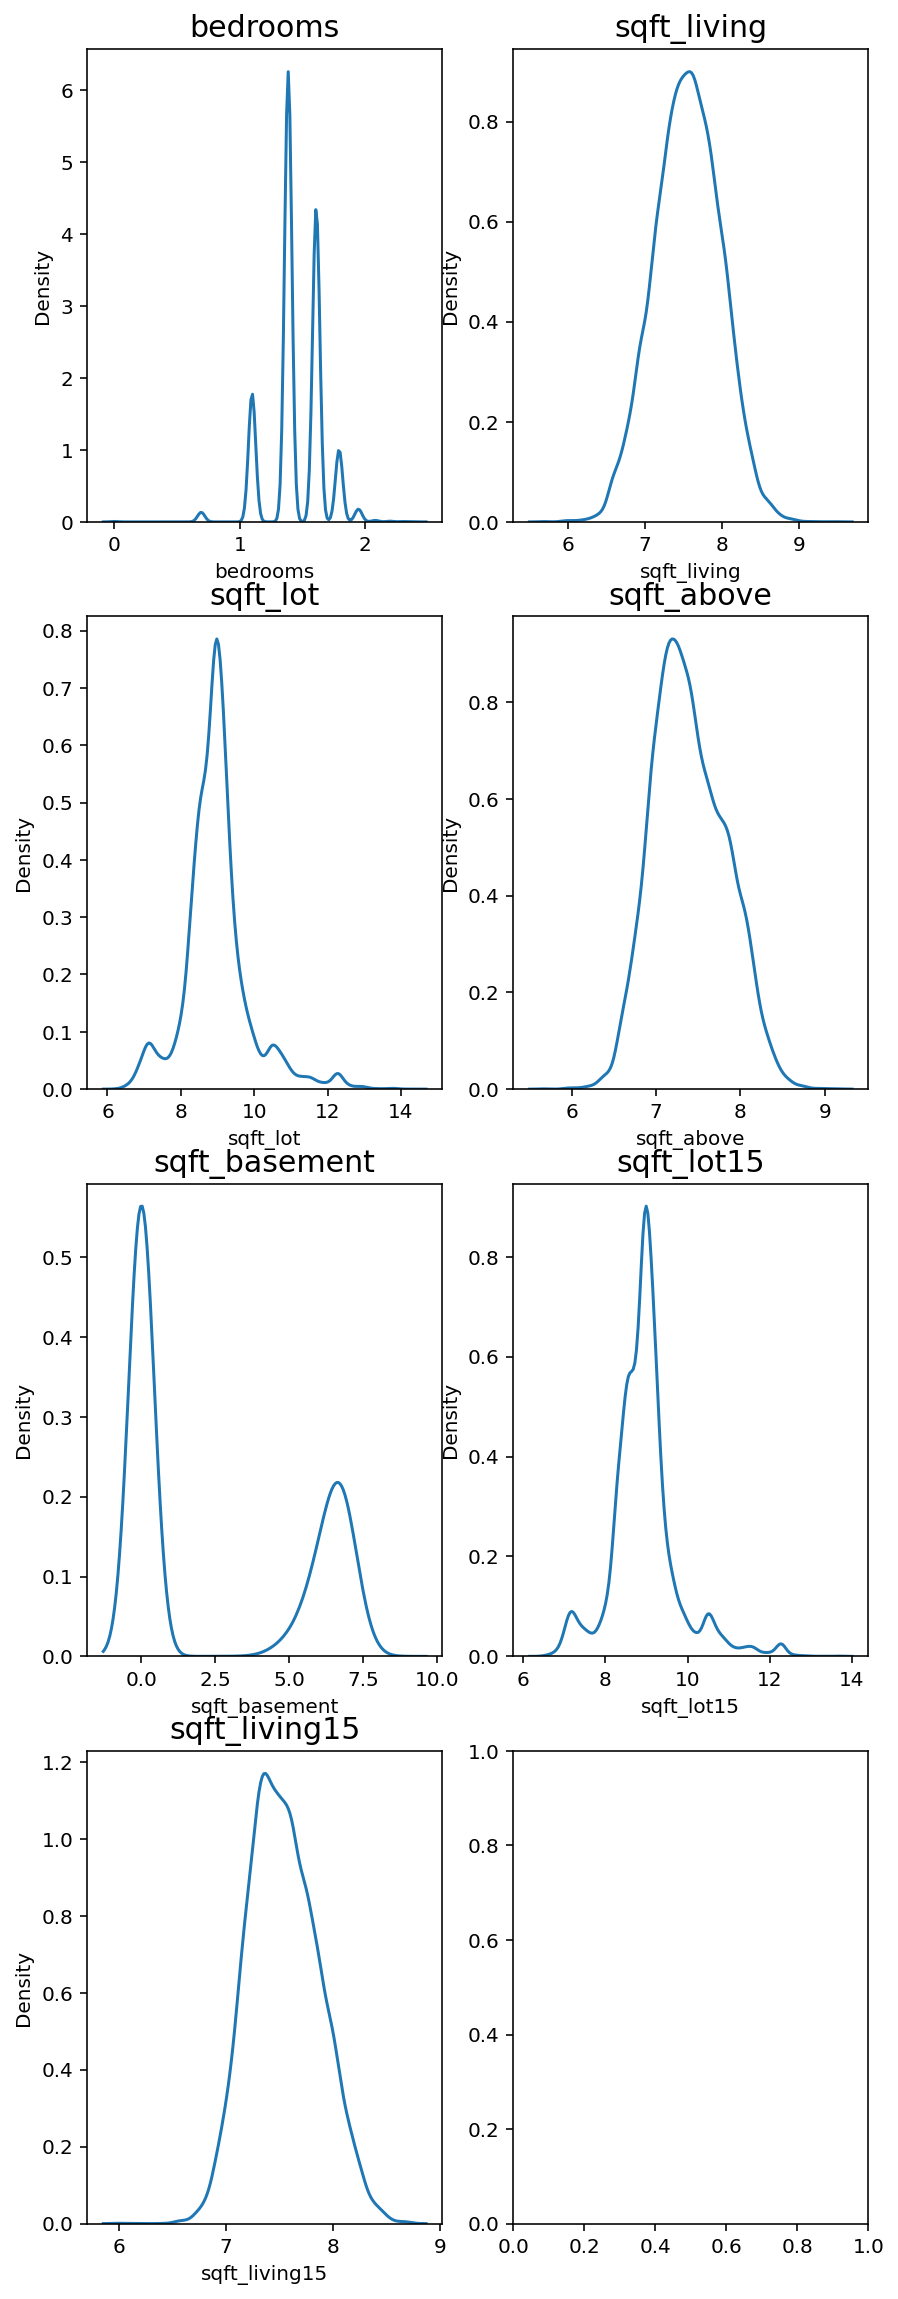

In [25]:
fig, ax = plt.df_testplots(4, 2, figsize=(7, 20))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(df_train=df_train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

그렇다면 왜 로그 변환은 분포의 치우침을 줄어들게 만드는 걸까요?
이는 로그 함수의 형태를 보면 알 수 있습니다. 아래의 일반적인 로그 함수를 살펴봅시다.

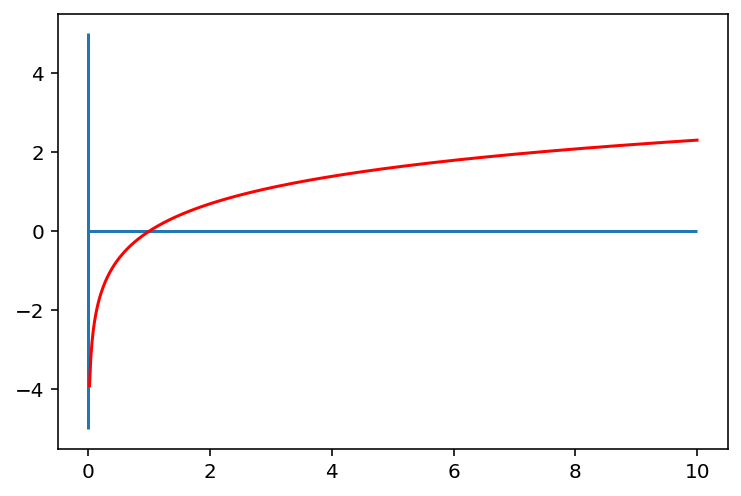

In [26]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

위와 같은 로그 함수의 특징은 다음과 같습니다.

0 < x < 10<x<1 범위에서는 기울기가 매우 가파릅니다. 즉, xx의 구간은 (0, 1)(0,1)로 매우 짧은 반면, yy의 구간은 (-/infty, 0)(−∞,0)으로 매우 큽니다.  
따라서 0에 가깝게 모여있는 값들이 xx로 입력되면, 그 함수값인 yy 값들은 매우 큰 범위로 벌어지게 됩니다.  
즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가집니다.  
반면, xx값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아집니다.  
이는 곧 큰 xx값들에 대해서는 yy값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 xx를 비교적 작은 yy값의 구간 내에 모이게 하는 특징을 가집니다.  
위와 같은 특성 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼질 수 있는 것이죠.  

왜 한쪽으로 치우친 분포를 로그 변환을 취하게 되면 정규분포 모양으로 고르게 분포하게 될 수 있는지 이해가 되시나요?  

그렇다면 우리가 맞추어야 할 타겟인 집의 가격, 즉 df_train[price]의 분포를 로그 변환했을 때 결과를 유추해봅시다.  
원래 price의 분포는 다음과 같습니다.

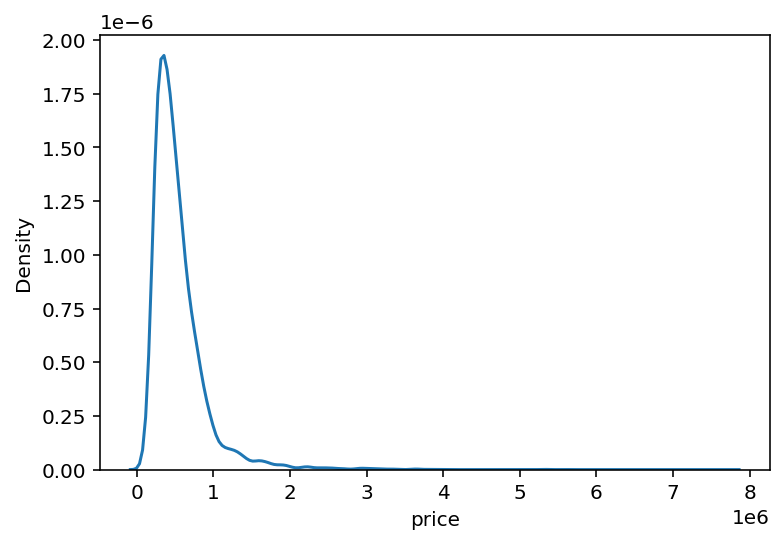

In [27]:
sns.kdeplot(y)
plt.show()

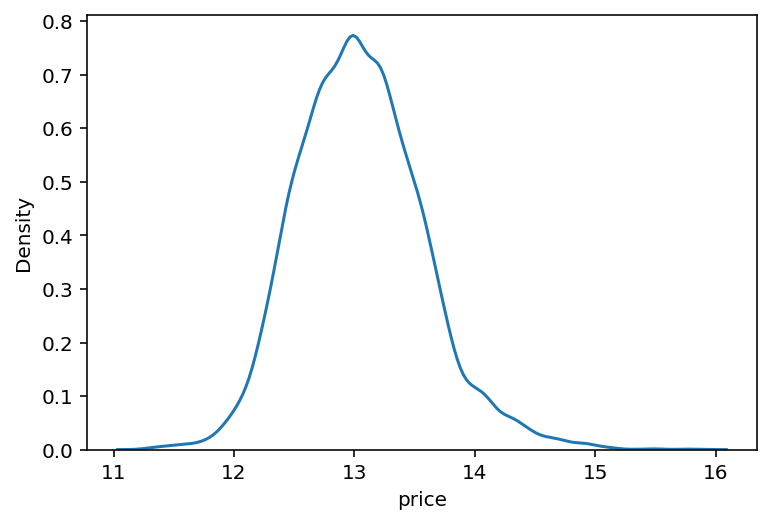

In [28]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [29]:
df_test = df_train.iloc[train_len:, :]
x = df_train.iloc[:train_len, :]

print(x.shape)
print(df_test.shape)

(15035, 19)
(6555, 19)


### 모델 설계

✓ 모델링  
이제 본격적으로 학습시킬 모델을 준비합니다. Baseline 커널에서는 여러 가지 모델을 함께 사용해서 결과를 섞는, 블렌딩(blending) 이라는 기법을 활용합니다.  

블렌딩이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법입니다.  
블렌딩은 앙상블 기법이라고 하기도 하는데요, 자세한 내용을 다음 포스팅에서 살짝 읽어보겠습니다.

In [30]:
# Average Blending
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [31]:
# Cross Validation
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

얍💢


In [34]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


In [36]:
# Make df_testmission File
#cross_val_score() 함수는 회귀모델을 전달할 경우 $R^2$ 점수를 반환합니다.

def AveragingBlending(models, x, y, df_test_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(df_test_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [37]:
y_pred = AveragingBlending(models, x, y, df_test)
print(len(y_pred))
y_pred

6555


array([1361676.91242777,  308900.55888961,  786583.53874638, ...,
       1693771.62246729,  415635.76190782,  341572.97685942])

In [42]:
df_testmission_path = 'C:/project/aiffel_exp/exp5_kaggle/sample_df_testmission.csv'
df_testmission = pd.read_csv(df_testmission_path)
df_testmission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [43]:
# id와 price로 구성된 데이터프레임
result = pd.df_trainFrame({
    'id' : df_test_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15208,1.361677e+06
1,15209,3.089006e+05
2,15210,7.865835e+05
3,15211,2.143299e+05
4,15212,4.413795e+05


In [45]:
my_df_testmission_path = 'C:/project/aiffel_exp/exp5_kaggle/sample_df_testmission.csv'
result.to_csv(my_df_testmission_path, index=False)

print(my_df_testmission_path)

C:/project/aiffel_exp/exp5_kaggle/sample_submission.csv


### 캐글에 제출하기

### 다시 데이터 준비하기

In [52]:
train_df_train_path = 'C:/project/aiffel_exp/exp5_kaggle/train.csv'
test_df_train_path = 'C:/project/aiffel_exp/exp5_kaggle/test.csv'

train = pd.read_csv(train_df_train_path)
test = pd.read_csv(test_df_train_path)

print('얍💢')

얍💢


In [53]:
# int형 데이터로 처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [54]:
# 타겟데이터 컬럼 변수에 넣고 삭제
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [55]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [56]:
# test 데이터도 
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [57]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

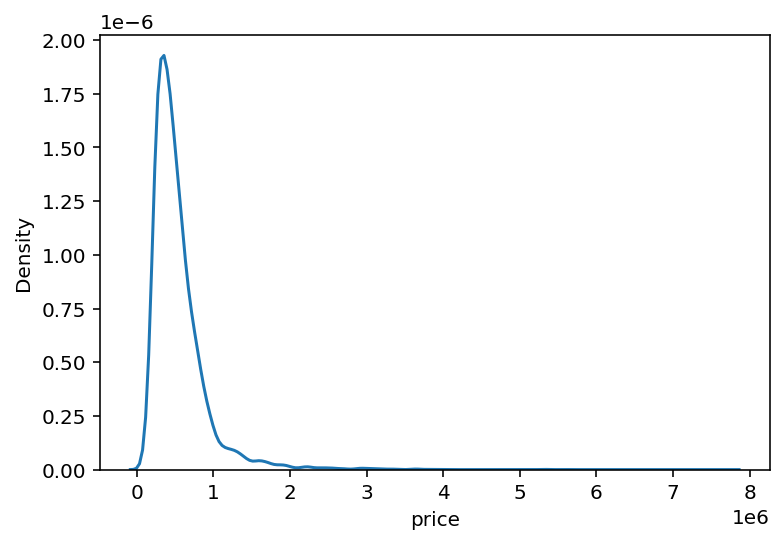

In [58]:
"""
seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인해주세요!
"""
sns.kdeplot(y)
plt.show()

In [61]:
'''
y는 np.log1p() 함수를 통해 로그 변환을 해주고, 
나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌리겠습니다. 
np.exp1m()은 np.log1p()과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환해 줍니다.
'''
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

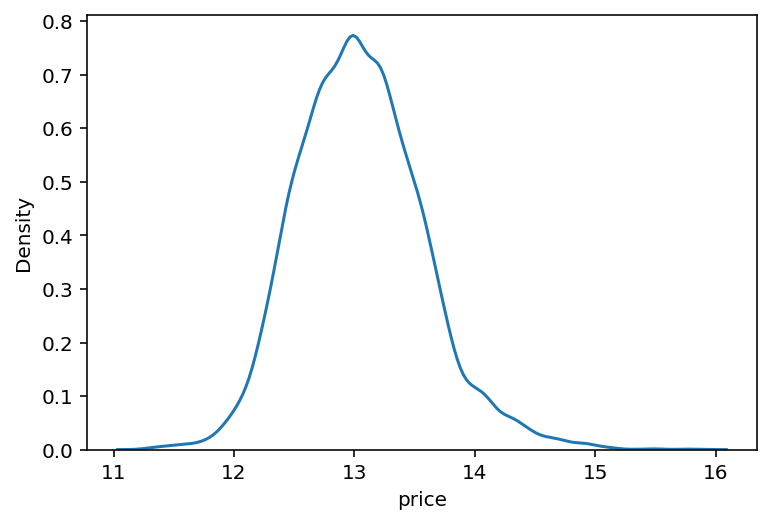

In [62]:
sns.kdeplot(y)
plt.show()

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int32  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

### 다양한 실험을 위해 함수 만들기

In [64]:
# RSME 계산

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


In [65]:
'''
대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE를 계산하기 위해 다음과 같은 함수를 만들어놓겠습니다.
한 가지 주의해야 할 것은, y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다는 점입니다.

exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을 수 있겠죠!
'''
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [66]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [67]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [68]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [69]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # df_train frame에 저장
    score_df = pd.df_trainFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.6704088949,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125367.2973747959}

In [71]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.df_trainFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125367.297375
LGBMRegressor,111920.367359
XGBRegressor,110318.670409


### 하이퍼파라미터 튜닝, 그리드 탐색

In [72]:
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


#### gridsearchCV?
* param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
* coring : 모델의 성능을 평가할 지표
* cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
* verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
* n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [73]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [74]:
model = LGBMRegressor(random_state=random_state)

print('얍💢')

얍💢


In [75]:
grid_model = GridSearchCV(model, param_grid=param_grid, /
                        scoring='neg_mean_squared_error', /
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [76]:
#  실험 결과 저장
grid_model.cv_results_

{'mean_fit_time': array([0.04986663, 0.07380314, 0.13942671, 0.23417373]),
 'std_fit_time': array([0.00178379, 0.00302408, 0.00182795, 0.00212947]),
 'mean_score_time': array([0.00658245, 0.00837774, 0.0127665 , 0.02094374]),
 'std_score_time': array([0.00079784, 0.00079736, 0.00116318, 0.00089218]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [77]:
# 실험결과에서 원하는 값만 추출1
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [78]:
# 실험결과에서 원하는 값만 추출2
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [79]:
# 추출한 값을 테이터 프레임으로 테이블화
results = pd.df_trainFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [80]:
# RMSE 점수 확인
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


앗, 하지만 아직도 위에서 보았던 10만 단위의 RMSE와는 값의 크기가 아주 다른 것 같습니다.

그 이유는 price에 있습니다. 위에서 우리는 price의 분포가 한쪽으로 치우쳐져 있는 것을 보고 log 변환을 했었죠.
그 후 RMSE 값을 계산하기 위한 함수에서는 np.expm1 함수를 활용해 다시 원래대로 복원한 후 RMSE 값을 계산했습니다.

하지만 그리드 탐색을 하면서는 np.expm1()으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 price 데이터에서 손실함수값을 계산한 것이죠.
따라서 사실, 위의 데이터 프레임에 나타난 값은 정확히 말하면 RMSE가 아니라 RMSLE, 즉 Root Mean Squared Log Error 입니다.
log를 취한 값에서 RMSE를 구했다는 뜻이죠!

이에 맞게 컬럼의 이름을 RMSLE로 변환해 주도록 하겠습니다. 판다스에서 컬럼의 이름 변환은 rename으로 할 수 있습니다.

In [81]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [82]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [83]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', /
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.df_trainFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [84]:
# 가장 좋은 조합 체크
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [92]:
# 해당 조합으로 구성한 모델과 학습 후 예측
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([14.11202067, 12.71849347, 13.52092457, ..., 14.42214958,
       12.9088143 , 12.69894979])

In [93]:
# 예측결과에 np.expm1`을 씌워서 리스케일
prediction = np.expm1(prediction)
prediction

array([1345155.15609376,  333864.49141891,  744838.89652063, ...,
       1834255.12502788,  403855.25797189,  327402.87855805])

In [95]:
df_testmission_path = 'C:/project/aiffel_exp/exp5_kaggle/sample_df_testmission.csv'
df_testmission = pd.read_csv(df_testmission_path)
df_testmission.head()

,id,price
0,15208,1.361677e+06
1,15209,3.089006e+05
2,15210,7.865835e+05
3,15211,2.143299e+05
4,15212,4.413795e+05


In [100]:
df_testmission['price'] = prediction
df_testmission.head()

,id,price
0,15208,1.345155e+06
1,15209,3.338645e+05
2,15210,7.448389e+05
3,15211,1.974053e+05
4,15212,4.289361e+05


In [102]:
'''
단, 앞으로는 많은 실험이 있을 예정이니 파일 이름에 모델의 종류와 위에서 확인했던 
RMSLE 값을 넣어주면 제출 파일들이 깔끔하게 관리될 것입니다!
'''
df_testmission_csv_path = '{}/df_testmission_{}_RMSLE_{}.csv'.format('C:/project/aiffel_exp/exp5_kaggle', 'lgbm', '0.164399')
df_testmission.to_csv(df_testmission_csv_path, index=False)
print(df_testmission_csv_path)

C:/project/aiffel_exp/exp5_kaggle/submission_lgbm_RMSLE_0.164399.csv


In [105]:
"""
아래의 과정을 수행하는 `save_df_testmission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `df_testmission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_df_testmission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    df_testmission_path = 'C:/project/aiffel_exp/exp5_kaggle/sample_df_testmission.csv'
    df_testmission = pd.read_csv(df_testmission_path)
    df_testmission['price'] = prediction
    df_testmission_csv_path = '{}/df_testmission_{}_RMSLE_{}.csv'.format('C:/project/aiffel_exp/exp5_kaggle', model_name, rmsle)
    df_testmission.to_csv(df_testmission_csv_path, index=False)
    print('{} saved!'.format(df_testmission_csv_path))

## 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!


#### 튜닝해볼 수 있는 모델 클래스 인자
대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같습니다.

* max_depth : 의사 결정 나무의 깊이, 정수 사용
* learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
* n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
* num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
* boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

### 0. 루브릭

* 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 df_testmission까지 전과정이 성공적으로 진행되었는가?
* 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
* 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

### 추가 학습자료

* Part 1. Introduction to Ensemble Learning  
https://df_testinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.
* 결정계수 R squared  
https://ltlkodae.tistory.com/19